# Visualization of Tree-Ring Watermark's Detection for ImageNet-Guided Diffusion


In [1]:
# Package imports
import wandb, os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from IPython.display import display, Image

# Relative imports
from tree_ring import *
from guided_diffusion import *
from distortions import *
from utils import *

# Experiment name
experiment_name = "Vis_Tree_Ring_Detect_Guided"

# Experiment parameters
dataset_name = "Tiny-ImageNet"
distortion_strengths = [0, 0.2, 0.5, 0.8, 1]
default_distortion_strength = 0.5
image_size = 64
labels = [8]
tree_ring_paras = dict(
    w_channel=2,
    w_pattern="ring",
    w_mask_shape="circle",
    w_radius=10,
    w_measurement="l1_complex",
    w_injection="complex",
)
# Parse the number of DDIM steps, which is 50 by default
num_ddim_steps = int(
    get_default_guided_diffusion_paras(image_size)["timestep_respacing"][4:]
)
# Seeds
distortion_seed = 0
diffusion_seed = 0
message_seed = 0
key_seed = 0  # not affecting the results since we have only one key


# Wandb and device setup
os.environ["WANDB_DIR"] = f"results/{experiment_name}/"
os.environ["WANDB_MODE"] = "dryrun"
os.environ["WANDB_SILENT"] = "true"
wandb.init(
    project=experiment_name,
    name=f"labels={labels}_diffusion_seed={diffusion_seed}",
    config={
        "dataset_name": dataset_name,
        "distortion_strengths": distortion_strengths,
        "default_distortion_strength": default_distortion_strength,
        "image_size": image_size,
        "labels": labels,
        "distortion_strength_paras": distortion_strength_paras,
        "tree_ring_paras": tree_ring_paras,
        "guided_diffusion_paras": get_default_guided_diffusion_paras(image_size),
        "num_ddim_steps": num_ddim_steps,
        "diffusion_seed": diffusion_seed,
        "message_seed": message_seed,
        "key_seed": key_seed,
    },
    save_code=False,
)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Implement the Common Natural Image Distortions


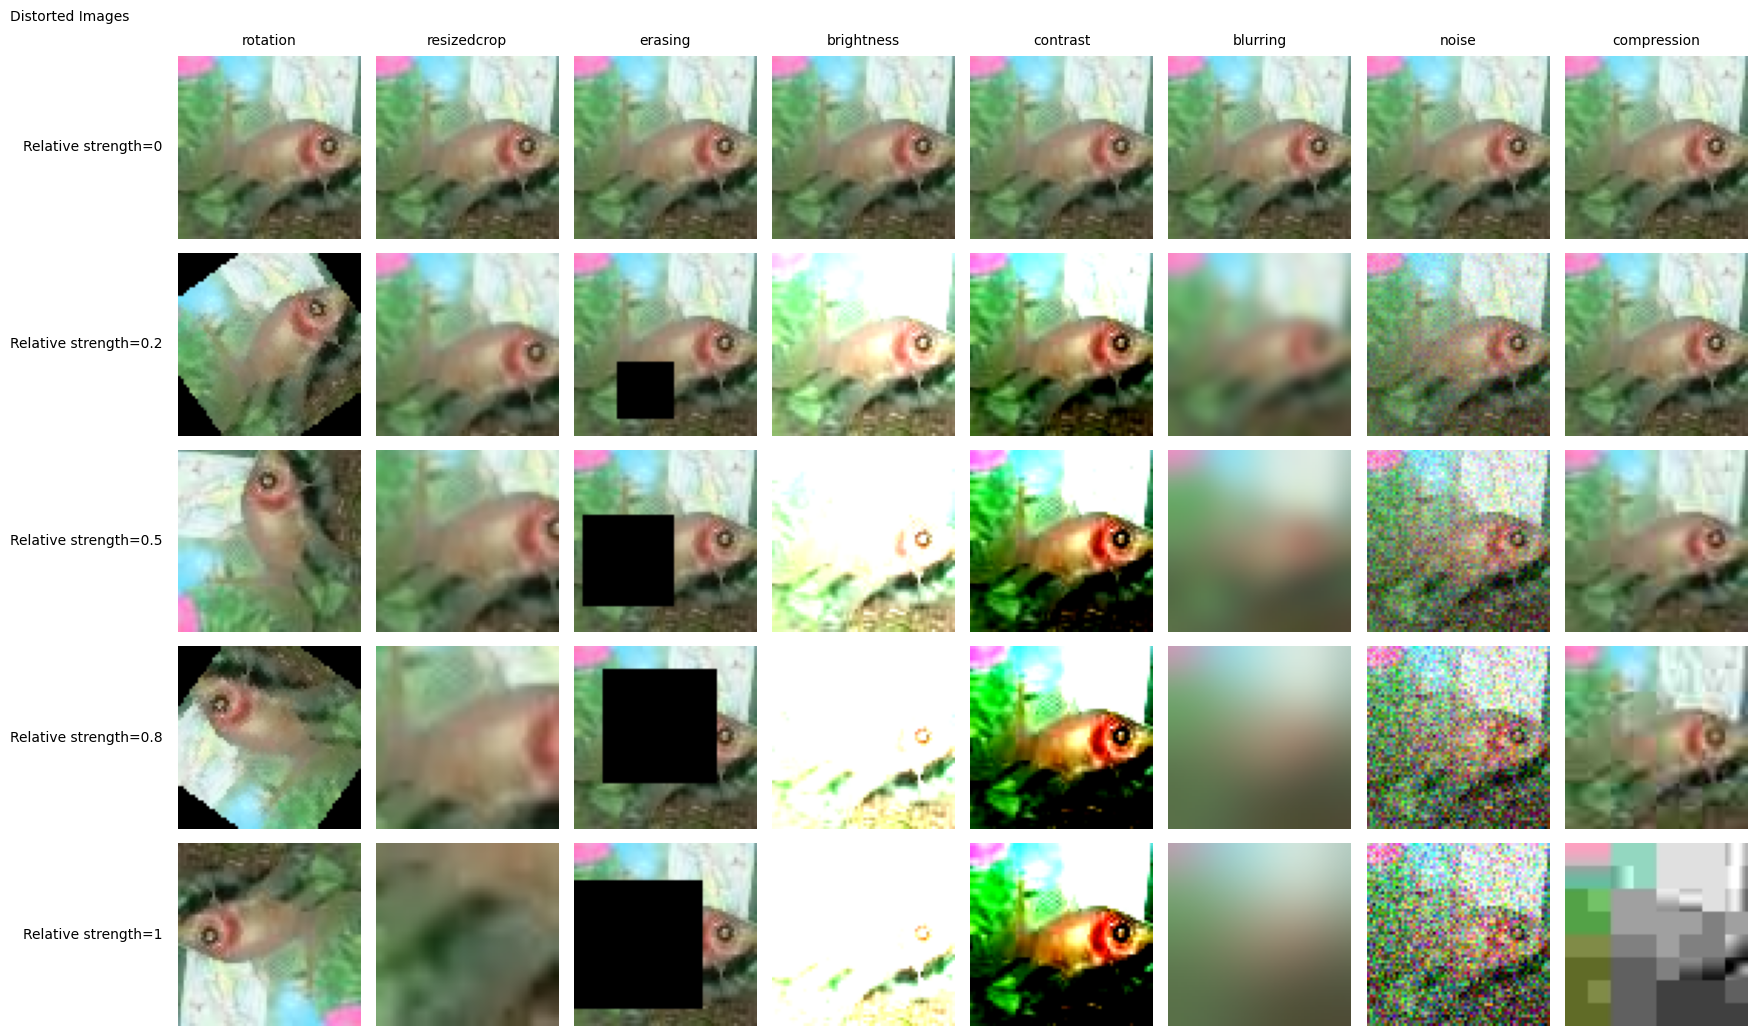

In [2]:
# Load imagenet subset
dataset, class_names = load_imagenet_subset(dataset_name)
images = to_pil(dataset[0][0])

# Distort images
distorted_images = []
for distortion_type in distortion_strength_paras.keys():
    distorted_images_single_type = []
    for strength in distortion_strengths:
        # Apply distortion
        distorted_images_single_type += apply_distortion(
            images,
            distortion_type,
            strength=strength,
            distortion_seed=distortion_seed,
            relative_strength=True,
            return_image=True,
        )
    distorted_images.append(distorted_images_single_type)

# Visualize distorted images
fig = visualize_image_grid(
    images=distorted_images,
    col_headers=list(distortion_strength_paras.keys()),
    row_headers=[f"Relative strength={s}" for s in distortion_strengths],
    fontsize=10,
    column_first=True,
    title="Distorted Images",
)
save_figure_to_file(fig, f"./results/{experiment_name}/distorted_images.jpg")

## How Distorted Tree-Ring Watermarks are Changing through Backward Diffusion Sampling


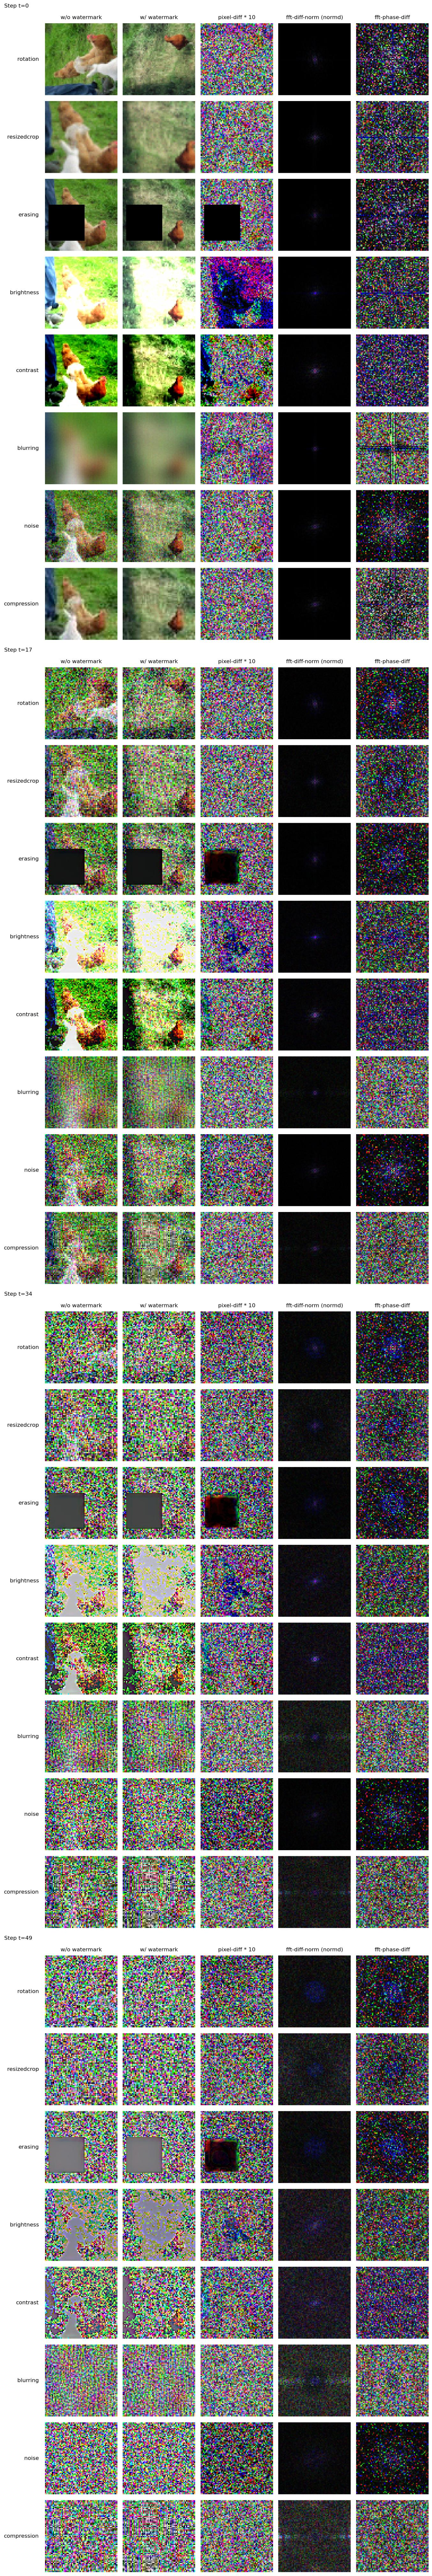

In [3]:
# Load guided diffusion models which are class-conditional diffusion models trained on ImageNet
model, diffusion = load_guided_diffusion_model(image_size, device)


# Generate images without watermark
images_wo = guided_diffusion_without_watermark(
    model,
    diffusion,
    labels,
    image_size,
    diffusion_seed=diffusion_seed,
    return_image=True,
)

# Generate one watermark message (which is the key in tree-ring's paper)
message = generate_message(
    message_seed=message_seed,
    image_size=image_size,
    tree_ring_paras=tree_ring_paras,
    device=device,
)

# Generate one watermark key (which is the mask in tree-ring's paper)
key = generate_key(
    key_seed=key_seed,
    image_size=image_size,
    tree_ring_paras=tree_ring_paras,
    device=device,
)

# Generate images with watermark
images_w = guided_diffusion_with_watermark(
    model,
    diffusion,
    labels,
    keys=key,
    messages=message,
    tree_ring_paras=tree_ring_paras,
    image_size=image_size,
    diffusion_seed=diffusion_seed,
    return_image=True,
)

# Distort images without and with watermark with save operation
distorted_images_wo = []
distorted_images_w = []
for distortion_type in distortion_strength_paras.keys():
    distorted_images = apply_distortion(
        [images_wo[0], images_w[0]],
        distortion_type,
        strength=default_distortion_strength,
        distortion_seed=distortion_seed,
        same_operation=True,
        relative_strength=True,
        return_image=True,
    )
    distorted_images_wo.append(distorted_images[0])
    distorted_images_w.append(distorted_images[1])


# Get iterators for reverse guided diffusion with and without watermark
images_prog_wo = reverse_guided_diffusion(
    model,
    diffusion,
    images=distorted_images_wo,
    image_size=image_size,
    progressive=True,
    return_image=True,
)
images_prog_w = reverse_guided_diffusion(
    model,
    diffusion,
    images=distorted_images_w,
    image_size=image_size,
    progressive=True,
    return_image=True,
)

# Reversed guided diffusion with and without watermark together step by step
figs = []
ddim_step_t = 0
for images_wo, images_w in zip(images_prog_wo, images_prog_w):
    # Unnormalize images
    images_wo_tensor = to_tensor(images_wo)
    images_w_tensor = to_tensor(images_w)
    # Pixel-wise diff between images with and without watermark
    pixel_diff = torch.abs(images_wo_tensor - images_w_tensor)
    # FFT diff between images with and without watermark
    images_wo_fft = torch.fft.fftshift(torch.fft.fft2(images_wo_tensor), dim=(-1, -2))
    images_w_fft = torch.fft.fftshift(torch.fft.fft2(images_w_tensor), dim=(-1, -2))
    fft_diff_norm = torch.abs(images_wo_fft - images_w_fft)
    fft_phase_diff = (
        torch.remainder(
            torch.abs(
                torch.atan2(images_wo_fft.imag, images_wo_fft.real)
                - torch.atan2(images_w_fft.imag, images_w_fft.real)
            ),
            np.pi,
        )
        / np.pi
    )
    figs.append(
        visualize_image_grid(
            [
                images_wo,
                images_w,
                to_pil(pixel_diff * 10, norm_type=None),
                to_pil(fft_diff_norm / fft_diff_norm.max(), norm_type=None),
                to_pil(fft_phase_diff, norm_type=None),
            ],
            col_headers=[
                "w/o watermark",
                "w/ watermark",
                "pixel-diff * 10",
                "fft-diff-norm (normd)",
                "fft-phase-diff",
            ],
            row_headers=list(distortion_strength_paras.keys()),
            fontsize=10,
            column_first=True,
            title=f"Step t={ddim_step_t}",
        )
    )
    wandb.log(
        {"Step t": ddim_step_t, "Figure": wandb.Image(save_figure_to_pil(figs[-1]))}
    )
    ddim_step_t += 1

# Concate selected figures into one and show
concatenate_figures(
    figs[0:-1:17] + [figs[-1]],
    save_path=f"./results/{experiment_name}/backward_diffusion.jpg",
    display=True,
)
# Make gif from the figures
make_gif(
    figs,
    save_path=f"./results/{experiment_name}/backward_diffusion.gif",
    display=True,
)

# Closing
plt.close("all")
wandb.finish()